In [1]:
%load_ext tensorboard

In [2]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import requests
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
import pathlib

import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import datetime

2022-11-16 13:56:57.115630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
os.environ['TF_CPP_MIN_LEVEL'] = '0'
np.set_printoptions(precision=3, suppress=True)
# stops the plt warnings
tf.get_logger().setLevel('ERROR')

In [4]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
time_save = now.strftime("%Hh%M")
dt_save = now.strftime("%d%m%Y")
# print("ddmmyyyy =", dt_save)
# print("HMS =", time_save)

# folder path to save model 
sp_model = r'saved_models/tf_tensor/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
# print('File count:', sc_model)

In [5]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
edgeFiles = list()
testFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    # print(testFiles)

In [6]:
edgeFiles = [img for img in edgeFiles if ".jpg" in img]
# print(type(edgeFiles))
# print(edgeFiles[0])

In [7]:
batch_size = 16
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


2022-11-16 13:57:02.665351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [11]:
class_names = train_ds.class_names
test_label = test_ds.class_names

In [12]:
# augmentation toegevoegen
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(25.5),
  layers.RandomZoom(0.6),  
])

In [13]:
# augmentation toegevoegen
image, label = next(iter(train_ds))

In [14]:
# augmentation toegevoegen
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

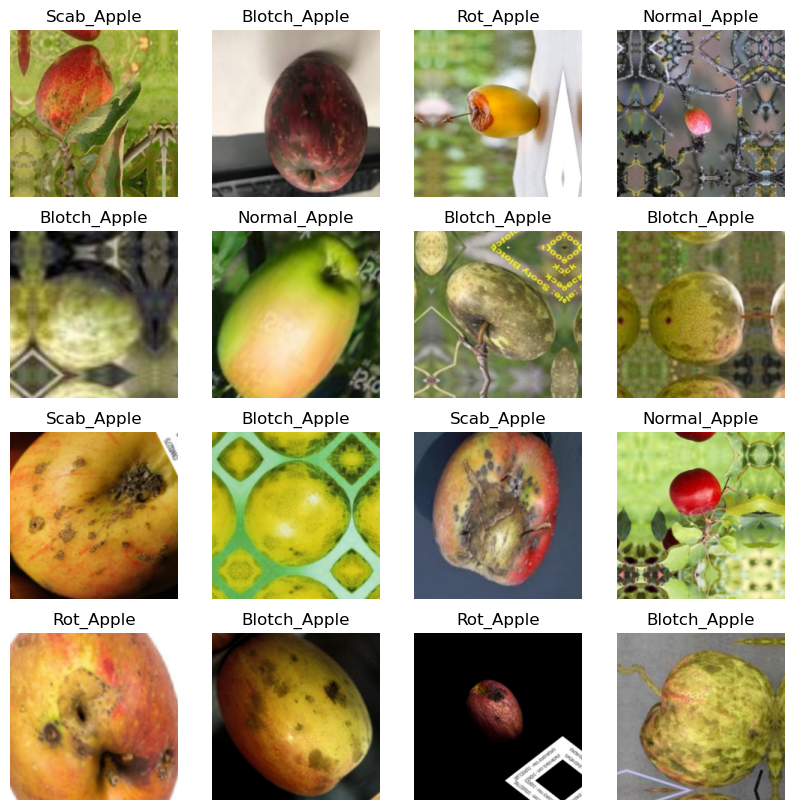

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_image = data_augmentation(images, training = True)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

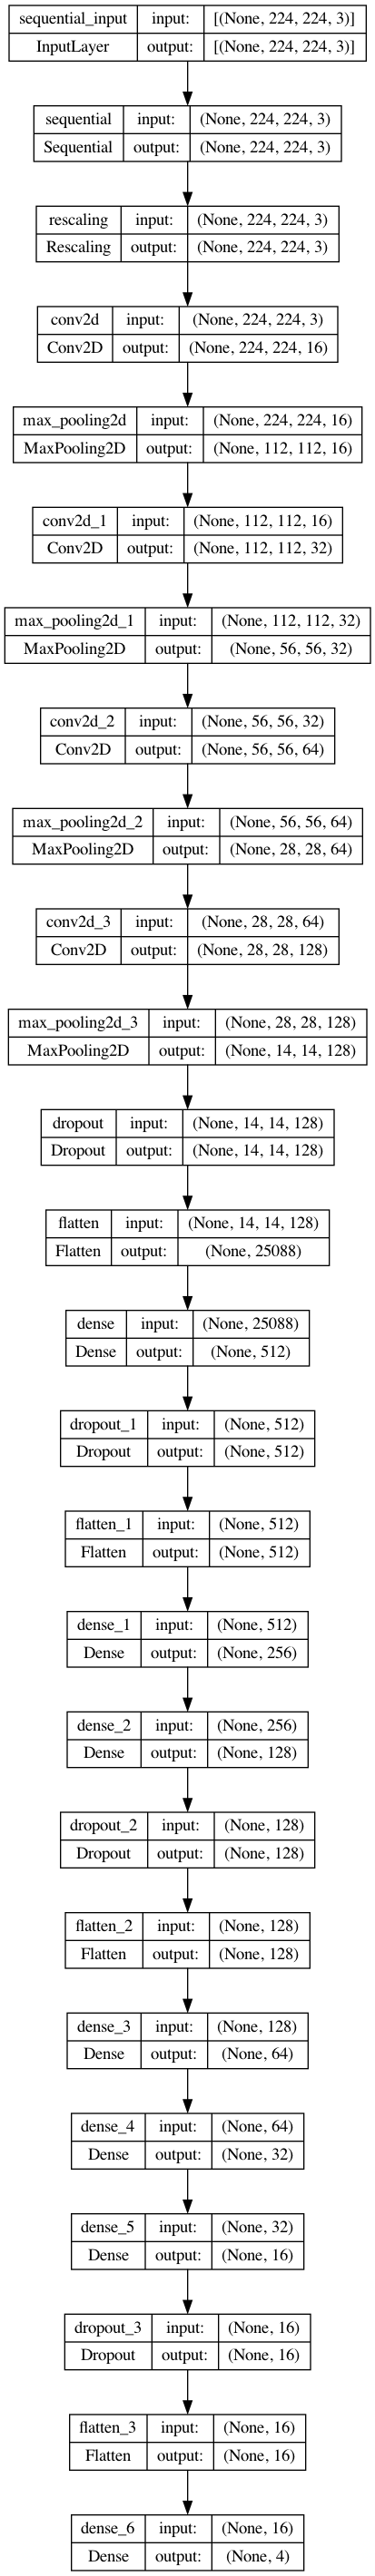

In [16]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate=0.3 ),  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(rate=0.4 ),  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(rate=0.1 ),  
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),  
  layers.Dropout(rate=0.3 ),  
  layers.Flatten(),
  layers.Dense(num_classes)
])

keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbackEarly = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [20]:
epochs=35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/35


KeyboardInterrupt: 

In [ ]:
# Tensorboard
log_dir = "logs/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
score = model.evaluate(test_ds)


In [ ]:
loss, accuracy = model.evaluate(train_ds)

In [ ]:
from keras.models import load_model
model.save('saved_models/tf_tensor/model/tl_model_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.h5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(34, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.savefig('saved_models/tf_tensor/plt_fig/tl_fig' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch', 'Normal', 'Rot', 'Scab'])

cm_display.plot()
plt.savefig('saved_models/tf_tensor/plt_matrix/fig_matrix' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

In [ ]:
%tensorboard --logdir logs/